# Focality Branch
- find a way of simulating focal vs non-focal tasks

In [1]:
from glob import glob as glob
import torch as tr
import numpy as np

from PMmodel import *

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

# train and eval script

In [2]:
## task
nback=2
ntokens_og=3
num_pm_trials=3
edim_og=5
edim_pm=5
focal=1
pm_weight = 1
trseqlen = 25

## network
indim = edim_og+edim_pm
stsize = 20
batch=1
outdim=3
arch = 'wmem'

In [3]:
# model and task
if arch=='purewm': net = Net(indim,stsize,outdim)
elif arch=='wmem': net = Net_wmem(indim,stsize,outdim)
task = NBackPMTask(nback,ntokens_og,num_pm_trials,edim_og,edim_pm,focal,seed=132)


### train

In [51]:
def train(net,task,nepochs=1000,thresh=.99,pm_weight=1):
  weight=tr.FloatTensor([1,1,pm_weight])
  print(weight)
  lossop = tr.nn.CrossEntropyLoss()
  optiop = tr.optim.Adam(net.parameters(), lr=0.005)
  L = -np.ones([nepochs])
  A = -np.ones([nepochs])
  E = -np.ones([nepochs])
  acc,nembeds = 0,0
  for ep in range(nepochs):
    if ep%(nepochs/5)==0:
      print(ep/nepochs)
    # randomize emat
    if acc>thresh:
      task.sample_emat()
      nembeds+=1
    # generate data
    x_seq,y_seq = task.gen_seq(trseqlen)
    x_embeds,ytarget = task.embed_seq(x_seq,y_seq)
    # forward prop
    yhat = net(x_embeds)
    # collect loss through time
    loss,acc = 0,0
    for yh,yt in zip(yhat,ytarget):
      loss += weight[yt]*lossop(yh,yt)
      acc += yt==tr.argmax(tr.softmax(yh,1))
    acc = acc.numpy()/len(yhat)
    print('L',loss)
    # bp and update
    optiop.zero_grad()
    loss.backward()
    optiop.step()
    epoch_loss = loss.item()
    L[ep] = epoch_loss
    A[ep] = acc
    E[ep] = nembeds
  return net

In [54]:
task = NBackPMTask(nback,ntokens_og,num_pm_trials,edim_og,edim_pm,focal,seed=132)
net = Net(indim,stsize,outdim)
net = train(net,task,nepochs=1,pm_weight=100)

weights tensor([  1.,   1., 100.])
0.0
L tensor(28.2468, grad_fn=<AddBackward0>)


In [31]:
net1 = Net(indim,stsize,outdim)
task1 = NBackPMTask(nback,ntokens_og,num_pm_trials,edim_og,edim_pm,focal,seed=132)
net1 = train(net1,task1,nepochs=1000,pm_weight=10)

net2 = Net(indim,stsize,outdim)
task2 = NBackPMTask(nback,ntokens_og,num_pm_trials,edim_og,edim_pm,focal,seed=132)
net2 = train(net1,task1,nepochs=1000,pm_weight=0)

tensor([0.0833, 0.0833, 0.8333])
0.0
0.2
0.4
0.6
0.8
tensor([0.5000, 0.5000, 0.0000])
0.0
0.2
0.4
0.6
0.8


### eval

In [32]:
def eval_(net,task):
  teseqlen = 15
  neps = 1500
  score = -np.ones([neps,teseqlen])
  for ep in range(neps):
    # embedding matrix
    task.sample_emat()
    # generate data
    x_seq,y_seq = task.gen_seq(teseqlen,pm_trial_position=[5,9])
    x_embeds,ytarget = task.embed_seq(x_seq,y_seq)
    # forward prop
    yhat = net(x_embeds)
    ep_score = (ytarget == tr.softmax(yhat,-1).argmax(-1)).float().squeeze()
    score[ep] = ep_score 
  return score

In [33]:
score1 = eval_(net1,task2)
score2 = eval_(net2,task2)

(0, 1)

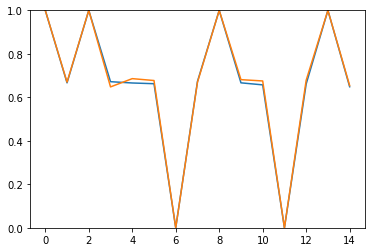

In [34]:
plt.plot(score1.mean(0))
plt.plot(score2.mean(0))
plt.ylim(0,1)